In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, to_timestamp, lit, explode, collect_set, weekofyear
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, DoubleType
import json
# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# --- load data ---
# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# TODO add day of week (und evtl week, month etc)! um mehr daten zu haben! sonst ist es nur ein (stunden)vektor

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("week", weekofyear("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))

# --- make pos/neg occurance and vector hour --- 
# 4. Get unique hours and days to create negative samples
time_combinations = df.select("hour", "day_of_week", "week").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

data = []
results = []

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]

    # TODO: glaub hier train und test sets erstellen
    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                .select("hour", "day_of_week", "week") \
                .distinct()

    #df_pos_raw.show()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Now add labels
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine both
    df_model = df_pos.union(df_neg)
    
    # Assemble features
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    # array for this species with 1 for hour where pos and 0 for neg
    #df_model.show()
    data.append((species_name, df_model.select("hour", "label")))

    # TODO next
    # --- split to test and train --- 

    # --- fit & predict --- 
    
    # Train logistic regression
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    model = lr.fit(df_model)
    
    # Make predictions
    #predictions = model.transform(df_model).select("hour", "day_of_week", "label", "prediction", "probability")
    predictions = model.transform(df_model).select("hour", "label", "prediction", "probability")
    #predictions.show()

    # --- evaluate (cal accuracy & f1 etc) --- 
    #from sklearn.model_selection import cross_val_score

    # Example: accuracy scores
    #scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    #print(scores.mean())
    # You can also do this for 'f1_weighted', 'precision_weighted', etc.

    
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="rawPrediction",  # default, but good to be explicit
        metricName="areaUnderROC"          # or "areaUnderPR"
    )
    
   # auc = evaluator.evaluate(predictions)
    #print(f"Area under ROC: {auc:.4f}")

    # --- gather metrices in a table for each model -> plot later or make some more calculations (mean etc)

    
    # Collect for inspection or saving
    results.append((species_name, predictions))

    print(f"✅ Trained model for {species_name}")



✅ Trained model for Crested Tit
✅ Trained model for Rook
✅ Trained model for Reed Bunting
✅ Trained model for Stock Dove
✅ Trained model for Yellowhammer
✅ Trained model for Eurasian Siskin
✅ Trained model for Eurasian Moorhen
✅ Trained model for Common Sandpiper
✅ Trained model for Eurasian Magpie
✅ Trained model for Gray Heron
✅ Trained model for Common Wood-Pigeon
✅ Trained model for Common Buzzard
✅ Trained model for Eurasian Tree Sparrow
✅ Trained model for Eurasian Kestrel
✅ Trained model for Short-toed Treecreeper
✅ Trained model for Eurasian Jay
✅ Trained model for Hawfinch
✅ Trained model for Water Rail
✅ Trained model for Rock Pigeon
✅ Trained model for Mistle Thrush
✅ Trained model for Long-tailed Tit
✅ Trained model for European Greenfinch
✅ Trained model for Common Crane
✅ Trained model for Eurasian Treecreeper
✅ Trained model for Common Raven
✅ Trained model for Graylag Goose
✅ Trained model for European Goldfinch
✅ Trained model for Common Kingfisher
✅ Trained model for 

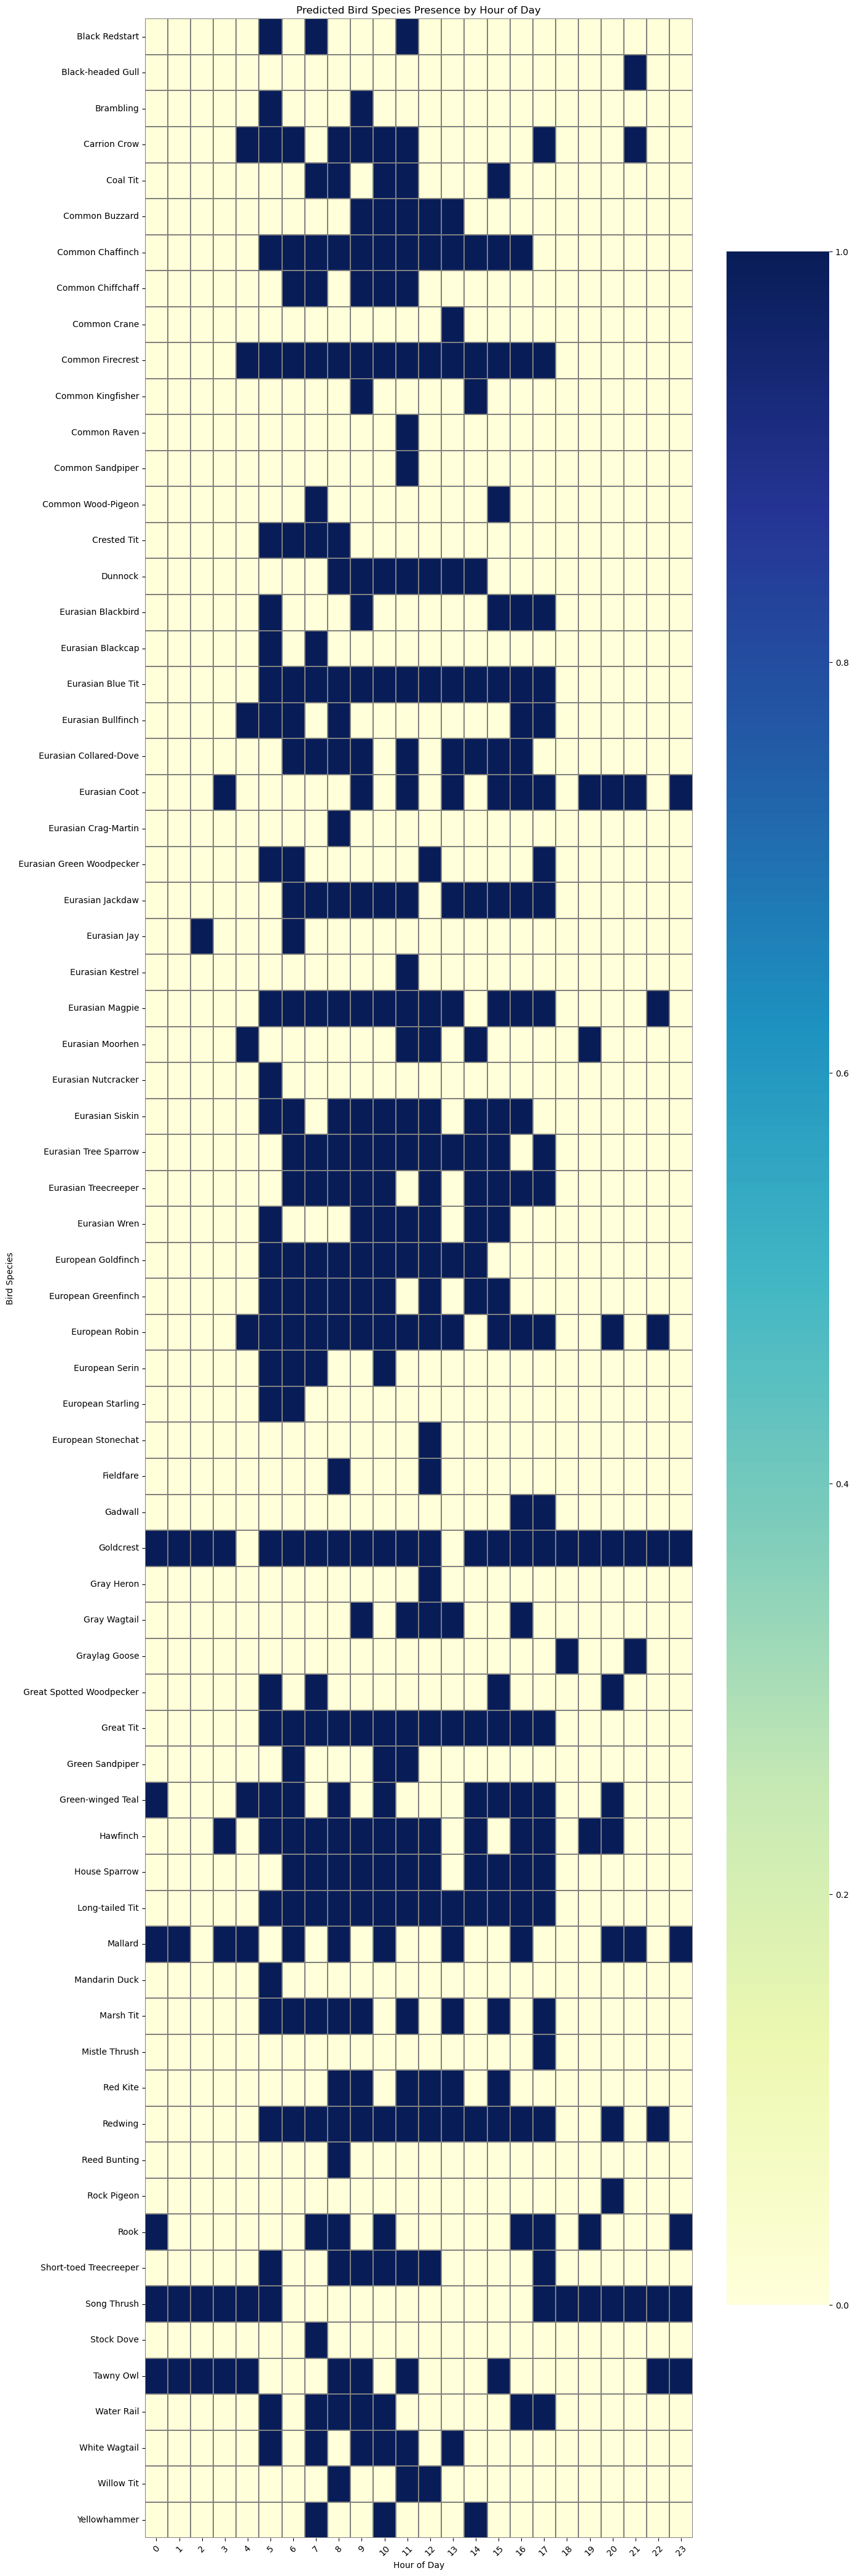

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_data = []

for species_name, data_df in data:
    # Get only hour and prediction columns
    pd_df = data_df.select("hour", "label").toPandas()
    pd_df["species"] = species_name
    all_data.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_data)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="label", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

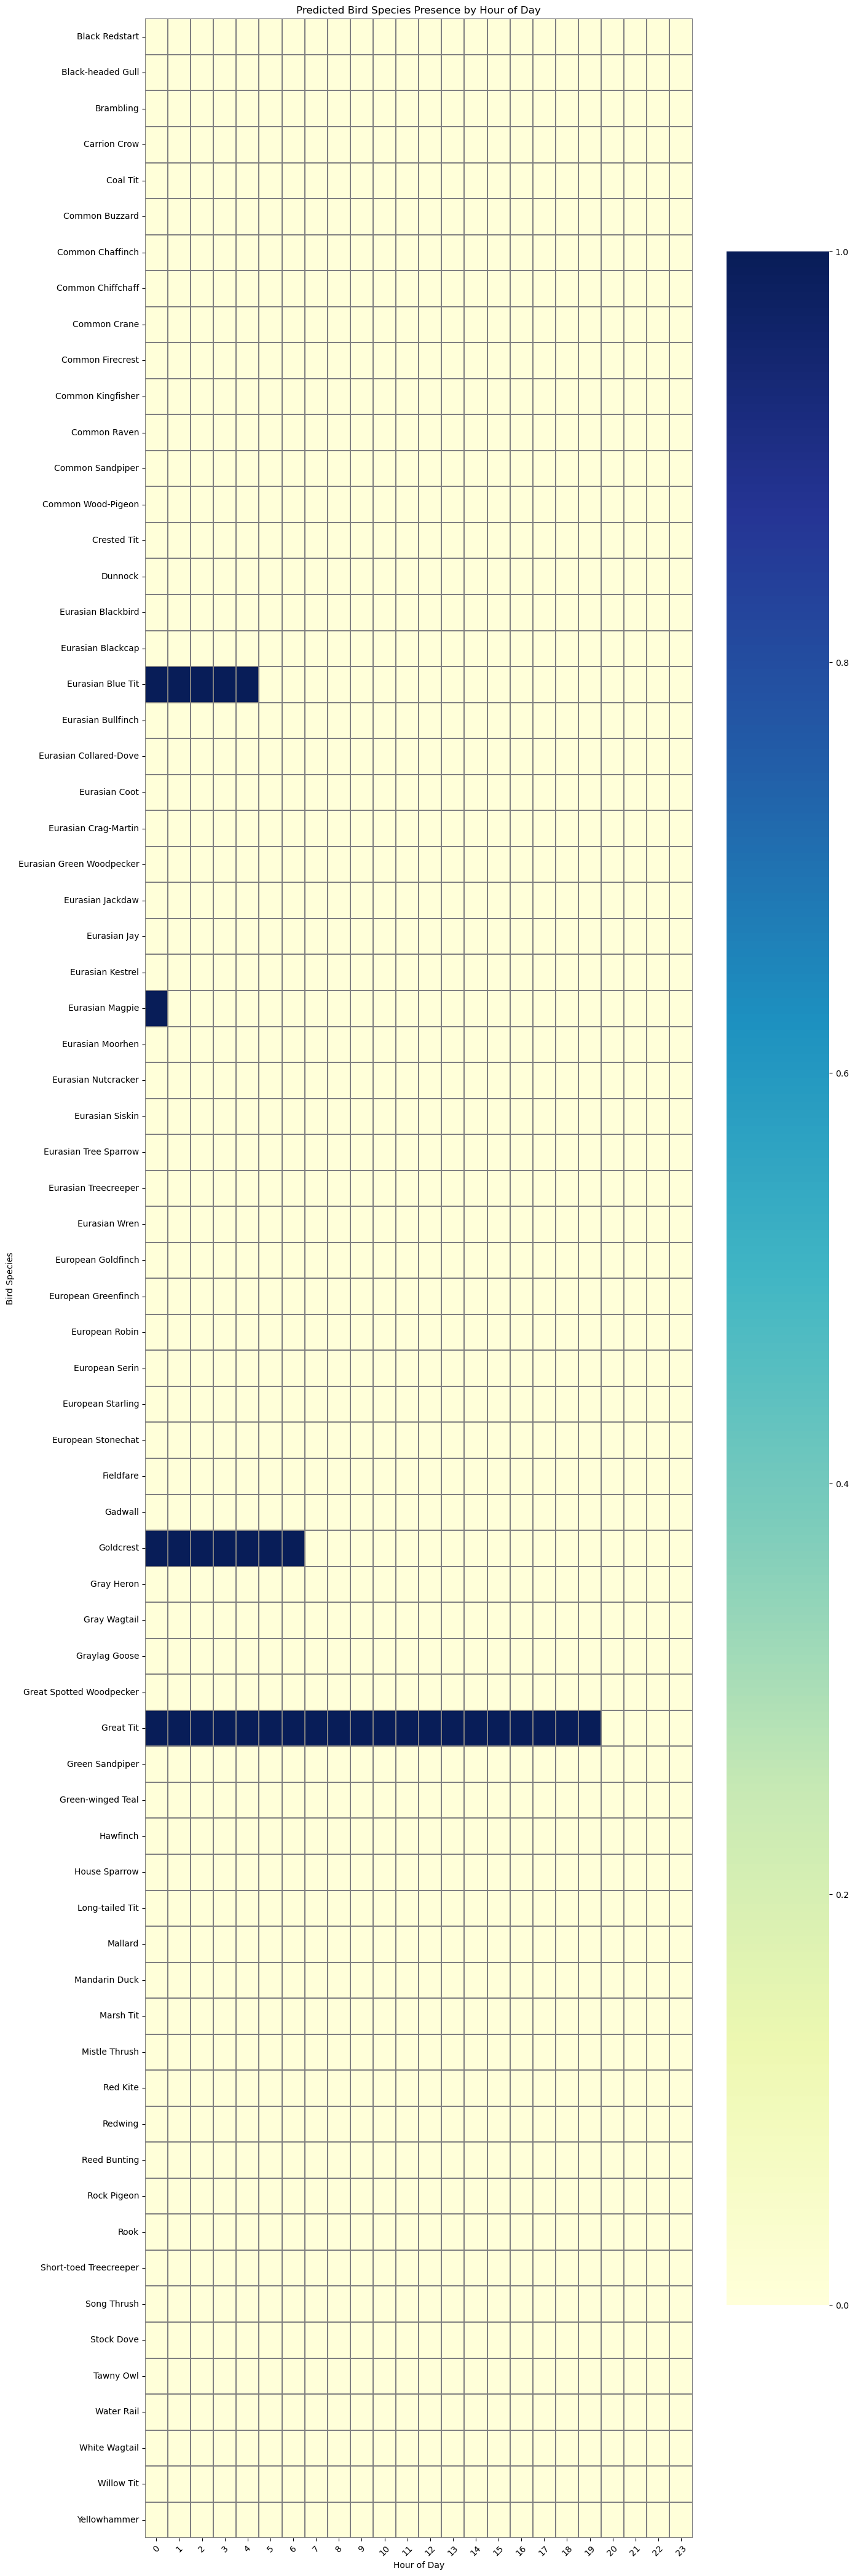

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_preds = []

for species_name, predictions_df in results:
    # Get only hour and prediction columns
    pd_df = predictions_df.select("hour", "prediction").toPandas()
    pd_df["species"] = species_name
    all_preds.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_preds)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="prediction", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Predicted Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, to_timestamp, lit, explode, collect_set, weekofyear
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, DoubleType
import json
# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("week", weekofyear("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))

# 4. Get unique hours and days to create negative samples
time_combinations = df.select("hour", "day_of_week", "week").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

results = []

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]

    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                .select("hour", "day_of_week", "week") \
                .distinct()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Now add labels
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine both
    df_model = df_pos.union(df_neg)
    
    # Assemble features
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    
        # --- Random Forest Classifier ---
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
    rf_model = rf.fit(df_model)
    
    # Make predictions
    predictions = model.transform(df_model).select("hour", "label", "prediction", "probability")

    results.append((species_name, predictions))

    print(f"✅ Trained model for {species_name}")

✅ Trained model for Crested Tit
✅ Trained model for Rook
✅ Trained model for Reed Bunting
✅ Trained model for Stock Dove
✅ Trained model for Yellowhammer
✅ Trained model for Eurasian Siskin
✅ Trained model for Eurasian Moorhen
✅ Trained model for Common Sandpiper
✅ Trained model for Eurasian Magpie
✅ Trained model for Gray Heron
✅ Trained model for Common Wood-Pigeon
✅ Trained model for Common Buzzard
✅ Trained model for Eurasian Tree Sparrow
✅ Trained model for Eurasian Kestrel
✅ Trained model for Short-toed Treecreeper
✅ Trained model for Eurasian Jay
✅ Trained model for Hawfinch
✅ Trained model for Water Rail
✅ Trained model for Rock Pigeon
✅ Trained model for Mistle Thrush
✅ Trained model for Long-tailed Tit
✅ Trained model for European Greenfinch
✅ Trained model for Common Crane
✅ Trained model for Eurasian Treecreeper
✅ Trained model for Common Raven
✅ Trained model for Graylag Goose
✅ Trained model for European Goldfinch
✅ Trained model for Common Kingfisher
✅ Trained model for 